In [1]:
import sys
import os
import warnings
import logging
import numpy as np
import pandas as pd
import random as rn
import tracemalloc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

from tensorflow.keras import backend as K

# import helper_functions.config as config
import helper_functions.data_functions as data_functions
#import helper_functions.plotting_functions as plotting_functions

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating

def warn(*args, **kwargs):
    pass

tf.get_logger().setLevel(logging.ERROR)
warnings.warn = warn

tf.random.set_seed(42)
np.random.seed(42)
rn.seed(42)
os.environ['PYTHONHASHSEED']=str(42)

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.2.0
Keras 2.3.0-tf

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [2]:
class NeuralNet:
    def __init__(self, hyperparameters, metrics, data):
        self.recurrent_unit_type = hyperparameters['recurrent_unit_type']
        self.statefullness = hyperparameters['statefullness']
        self.units = hyperparameters['units']
        self.learning_rate = hyperparameters['learning_rate']
        self.batch_size = hyperparameters['batch_size']
        self.past_history = hyperparameters['past_history']
        self.dropout = hyperparameters['dropout']
        self.class_0_weight = hyperparameters['class_0_weight']
        self.class_1_weight = hyperparameters['class_1_weight']
        self.output_bias = hyperparameters['initial_output_bias']
        self.future_target = hyperparameters['future_target']
        self.step = hyperparameters['step']
        self.test_data_frac = hyperparameters['test_data_frac']
        self.validation_data_frac = hyperparameters['validation_data_frac']
        self.training_epochs = hyperparameters['training_epochs']
        self.verbose = hyperparameters['verbose']
            
        self.metrics = metrics
        
        self.data = data
        
    def prep_data(self):
        # sort dataframe by date
        self.data = self.data.sort_values(by='date')
        
        # split data up into training, testing and validation sets
        num_observations = len(self.data)
        
        test_data = data.tail(int(len(self.data) * self.test_data_frac))
        leftover_data = data.head(int(len(self.data) * (1 - self.test_data_frac)))
        
        validation_data = data.tail(int(len(leftover_data) * self.validation_data_frac))
        training_data = data.head(int(len(leftover_data) * (1 - self.validation_data_frac)))
        
        self.steps_per_epoch = int((len(training_data)*0.01) // self.batch_size)
        self.validation_steps = int((len(validation_data)*0.01) // self.batch_size)

        # create training and vaildation data 
        x_train, y_train = data_functions.multivariate_data(
            training_data,
            self.past_history,
            self.future_target, 
            self.step
        )

        x_validation, y_validation = data_functions.multivariate_data(
            validation_data,
            self.past_history,
            self.future_target, 
            self.step
        )
        
        x_test, y_test = data_functions.multivariate_data(
            test_data,
            self.past_history,
            self.future_target, 
            self.step
        )

        # trim datasets so they are whole number multiples of the batch
        # size (needed for statefull LSTM)
        start_index = (x_train.shape[0] - (x_train.shape[0] % self.batch_size))
        end_index = x_train.shape[0]

        self.x_train = np.delete(x_train, range(start_index, end_index), axis=0)
        self.y_train = np.delete(y_train, range(start_index, end_index), axis=0)

        start_index = (x_validation.shape[0] - (x_validation.shape[0] % self.batch_size))
        end_index = x_validation.shape[0]

        self.x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
        self.y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
        
        start_index = (x_test.shape[0] - (x_test.shape[0] % self.batch_size))
        end_index = x_test.shape[0]

        self.x_test = np.delete(x_test, range(start_index, end_index), axis=0)
        self.y_test = np.delete(y_test, range(start_index, end_index), axis=0)

        input_dim = self.x_train.shape[-2:]
        self.input_shape = (self.batch_size, input_dim[0], input_dim[1])
        
        return True
    
    def build_model(self):
        
        model = tf.keras.models.Sequential()

        if self.recurrent_unit_type == 'LSTM':
            model.add(tf.keras.layers.LSTM(
                self.units,
                batch_input_shape = self.input_shape,
                stateful = self.statefullness,
                dropout = self.dropout
            ))
            
        elif self.recurrent_unit_type == 'GRU':
            model.add(tf.keras.layers.GRU(
                self.units,
                stateful = self.statefullness,
                dropout = self.dropout
            ))
            
        model.add(tf.keras.layers.Dense(
            1,
            activation = 'sigmoid',
            bias_initializer = self.output_bias)
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr = self.learning_rate),
            loss = data_functions.weighted_bce(self.class_0_weight, self.class_1_weight),
            metrics = self.metrics
        )
        
        self.model = model
        
        return True
        
    def train_model(self):
        history = self.model.fit(
            self.x_train,
            self.y_train,
            epochs = self.training_epochs,
            batch_size = self.batch_size,
            steps_per_epoch = self.steps_per_epoch,
            validation_data = (self.x_validation, self.y_validation),
            validation_steps = self.validation_steps,
#             class_weight = self.class_weight,
            verbose = self.verbose
        )
        
        return history
    
    def evaluate_model(self):
        results = self.model.evaluate(
            self.x_test,
            self.y_test,
            batch_size = self.batch_size,
            verbose = self.verbose
        )
        
        return results

In [3]:
# read data and grab features of intrest
data_file = '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_selective_box_cox.parquet'
data = pd.read_parquet(data_file)

# raw_data.drop([
#     'lat',
#     'lon',
#     'total_fires',
#     'veg',
#     'January',
#     'February',
#     'March',
#     'April',
#     'May',
#     'June',
#     'July',
#     'August',
#     'Septermber',
#     'October',
#     'November',
#     'December'
    
# ], inplace=True, axis=1)

# make sure data is sorted by date
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.sort_index()
data.reset_index(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 13 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   month             float32       
 2   apcp              float32       
 3   mean_air_2m       float32       
 4   mean_rhum_2m      float32       
 5   mean_dpt_2m       float32       
 6   mean_pres_sfc     float32       
 7   mean_uwnd_10m     float32       
 8   mean_vwnd_10m     float32       
 9   mean_cloud_cover  float32       
 10  ignition          int32         
 11  raw_lat           float32       
 12  raw_lon           float32       
dtypes: datetime64[ns](1), float32(11), int32(1)
memory usage: 191.9 MB


In [4]:
class_0_weight = ()
class_1_weight = ()
bins = data.groupby(['raw_lat', 'raw_lon'])

for name, spatial_bin in bins:
    fires = spatial_bin['ignition'].sum()
    
    if fires == 0:
        class_0_weight = class_0_weight + (1,)
        class_1_weight = class_1_weight + (1,)
    
    else:
        observations = len(spatial_bin)
        class_0_weight = class_0_weight + (((1 / (observations - fires))*(observations)/2.0),)
        class_1_weight = class_1_weight + (((1 / fires)*(observations)/2.0),)

In [5]:
raw_output_bias = np.log([fires/(observations - fires)])[0]
output_bias = tf.keras.initializers.Constant(raw_output_bias)

In [6]:
# metrics to monitor during the run

metrics = {
    'true_positives': keras.metrics.TruePositives(name='true_positives'),
    'false_positives': keras.metrics.FalsePositives(name='false_positives'),
    'true_negatives': keras.metrics.TrueNegatives(name='true_negatives'),
    'false_negatives': keras.metrics.FalseNegatives(name='false_negatives'), 
    'AUC': keras.metrics.AUC(name='AUC'),
    'matthews_correlation': data_functions.matthews_correlation,
    'F1': data_functions.f1
}

In [7]:
# set run hyperparameters

hyperparameters = {
    'recurrent_unit_type': 'LSTM',
    'statefullness': False,
    'units': 10,
    'learning_rate': 0.1,
    'batch_size': 16,
    'past_history': 8,
    'dropout': 0.1,
    'class_0_weight': class_0_weight,
    'class_1_weight': class_1_weight,
    'initial_output_bias': output_bias,
    'future_target': 1,
    'step': 1,
    'test_data_frac': 0.01,
    'validation_data_frac': 0.5,
    'training_epochs': 5,
    'verbose': 1
}

# set parameters to vary 

experimental_parameters = ['statefullness', 'RNN_type', 'past_history']

parameter_sets = {
    'Stateless LSTM, past history 4': [False, 'LSTM', 4],
    'Stateless LSTM, past history 8': [False, 'LSTM', 8],
    'Stateless LSTM, past history 16': [False, 'LSTM', 16],
    'Stateless LSTM, past history 32': [False, 'LSTM', 32],
    'Statefull LSTM, past history 4': [True, 'LSTM', 4],
    'Statefull LSTM, past history 8': [True, 'LSTM', 8],
    'Statefull LSTM, past history 16': [True, 'LSTM', 16],
    'Statefull LSTM, past history 32': [True, 'LSTM', 32],
    'Stateless GRU, past history 4': [False, 'GRU', 4],
    'Stateless GRU, past history 8': [False, 'GRU', 8],
    'Stateless GRU, past history 16': [False, 'GRU', 16],
    'Stateless GRU, past history 32': [False, 'GRU', 32],
    'Statefull GRU, past history 4': [True, 'GRU', 4],
    'Statefull GRU, past history 8': [True, 'GRU', 8],
    'Statefull GRU, past history 16': [True, 'GRU', 16],
    'Statefull GRU, past history 32': [True, 'GRU', 32]
}


# set up pandas dataframe to hold results

metric_names = ['loss'] + list(metrics.keys())
metric_mean_names = []
metric_std_names = []

for metric_name in metric_names:
    metric_mean_names.append(metric_name)
    metric_std_names.append(f'{metric_name}_stdev')
    
column_names = ['description', 'peak_memory', 'peak_memory_stdev'] + experimental_parameters + metric_mean_names + metric_std_names
results = pd.DataFrame(columns = column_names)

In [8]:
# Do training runs on experimental conditions

num_repititions = 2
total_training_runs = num_repititions * len(parameter_sets)

for description, parameter_set in parameter_sets.items():
    run_results = []
    memory_use = []
    
    for i in range(num_repititions):
        print(f'{description}, run {i}, {total_training_runs} remaining')

        LSTM_RNN = NeuralNet(hyperparameters, list(metrics.values()), data)

        LSTM_RNN.statefullness = parameter_set[0]
        LSTM_RNN.recurrent_unit_type = parameter_set[1]
        LSTM_RNN.batch_size = parameter_set[2]

        LSTM_RNN.prep_data()
        
        tracemalloc.start()
        LSTM_RNN.build_model()
        LSTM_RNN.train_model()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memory_use.append(peak)

        result = LSTM_RNN.evaluate_model()
        run_results.append(result)
        
        total_training_runs -= 1
        
        del LSTM_RNN.model
        K.clear_session()
        
    run_means = np.array(run_results).mean(axis=0)
    run_stdev = np.array(run_results).std(axis=0)
    peak_memory_mean = np.array(memory_use).mean()
    peak_memory_std = np.array(memory_use).std()
    result_row = [description, peak_memory_mean, peak_memory_std] + parameter_set + list(run_means) + list(run_stdev)
    results.loc[len(results)] = result_row    

Stateless LSTM, past history 4, run 0, 32 remaining
Epoch 1/5
4447/4447 [==============================] - 107s 24ms/step - loss: 3.1999 - true_positives: 595.0000 - false_positives: 16247.0000 - true_negatives: 914.0000 - false_negatives: 32.0000 - AUC: 0.5185 - matthews_correlation: -0.0011 - f1: 0.0531 - val_loss: 1.3846 - val_true_positives: 182.0000 - val_false_positives: 17606.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0161
Epoch 2/5
4447/4447 [==============================] - 105s 24ms/step - loss: 2.0457 - true_positives: 658.0000 - false_positives: 17079.0000 - true_negatives: 48.0000 - false_negatives: 3.0000 - AUC: 0.5073 - matthews_correlation: -3.5470e-04 - f1: 0.0582 - val_loss: 1.3548 - val_true_positives: 182.0000 - val_false_positives: 17606.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - v

2223/2223 [==============================] - 53s 24ms/step - loss: 2.9910 - true_positives: 1304.0000 - false_positives: 51469.0000 - true_negatives: 909.0000 - false_negatives: 30.0000 - AUC: 0.4391 - matthews_correlation: 2.6617e-04 - f1: 0.0590 - val_loss: 1.3470 - val_true_positives: 182.0000 - val_false_positives: 17602.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0180
Epoch 2/5
2223/2223 [==============================] - 53s 24ms/step - loss: 2.0143 - true_positives: 659.0000 - false_positives: 17082.0000 - true_negatives: 42.0000 - false_negatives: 1.0000 - AUC: 0.5062 - matthews_correlation: 3.2132e-04 - f1: 0.0644 - val_loss: 1.4778 - val_true_positives: 182.0000 - val_false_positives: 17602.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0180
Epoch 3/5
2223/2223 [==========================

555/555 [==============================] - 16s 28ms/step - loss: 2.9829 - true_positives: 1313.0000 - false_positives: 51405.0000 - true_negatives: 923.0000 - false_negatives: 39.0000 - AUC: 0.4723 - matthews_correlation: -0.0026 - f1: 0.0660 - val_loss: 1.6289 - val_true_positives: 182.0000 - val_false_positives: 17578.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5012 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0196
Epoch 2/5
555/555 [==============================] - 15s 26ms/step - loss: 1.9343 - true_positives: 601.0000 - false_positives: 17131.0000 - true_negatives: 26.0000 - false_negatives: 2.0000 - AUC: 0.4999 - matthews_correlation: -0.0013 - f1: 0.0638 - val_loss: 1.6278 - val_true_positives: 182.0000 - val_false_positives: 17578.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0196
Epoch 3/5
555/555 [==============================] - 13s 

4447/4447 [==============================] - 104s 23ms/step - loss: 3.1808 - true_positives: 1309.0000 - false_positives: 51590.0000 - true_negatives: 792.0000 - false_negatives: 25.0000 - AUC: 0.4581 - matthews_correlation: 6.3444e-04 - f1: 0.0542 - val_loss: 1.3540 - val_true_positives: 182.0000 - val_false_positives: 17606.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0161
Epoch 2/5
4447/4447 [==============================] - 101s 23ms/step - loss: 2.1144 - true_positives: 659.0000 - false_positives: 17072.0000 - true_negatives: 55.0000 - false_negatives: 2.0000 - AUC: 0.4979 - matthews_correlation: 6.7017e-12 - f1: 0.0583 - val_loss: 1.4966 - val_true_positives: 182.0000 - val_false_positives: 17606.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0161
Epoch 3/5
4447/4447 [========================

1111/1111 [==============================] - 28s 25ms/step - loss: 2.7447 - true_positives: 1329.0000 - false_positives: 51695.0000 - true_negatives: 656.0000 - false_negatives: 24.0000 - AUC: 0.5357 - matthews_correlation: 6.7198e-04 - f1: 0.0645 - val_loss: 1.7464 - val_true_positives: 182.0000 - val_false_positives: 17594.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0190
Epoch 2/5
1111/1111 [==============================] - 25s 23ms/step - loss: 1.9597 - true_positives: 605.0000 - false_positives: 17109.0000 - true_negatives: 62.0000 - false_negatives: 0.0000e+00 - AUC: 0.5037 - matthews_correlation: 0.0021 - f1: 0.0626 - val_loss: 1.7495 - val_true_positives: 182.0000 - val_false_positives: 17594.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0190
Epoch 3/5
1111/1111 [==========================

555/555 [==============================] - 15s 27ms/step - loss: 3.8164 - true_positives: 1279.0000 - false_positives: 49831.0000 - true_negatives: 2481.0000 - false_negatives: 73.0000 - AUC: 0.5333 - matthews_correlation: 0.0132 - f1: 0.0652 - val_loss: 1.6948 - val_true_positives: 182.0000 - val_false_positives: 17578.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0196
Epoch 2/5
555/555 [==============================] - 14s 24ms/step - loss: 1.8592 - true_positives: 603.0000 - false_positives: 17154.0000 - true_negatives: 3.0000 - false_negatives: 0.0000e+00 - AUC: 0.5277 - matthews_correlation: 0.0000e+00 - f1: 0.0639 - val_loss: 1.7264 - val_true_positives: 182.0000 - val_false_positives: 17578.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0196
Epoch 3/5
555/555 [==============================] 

2223/2223 [==============================] - 116s 52ms/step - loss: 2.8200 - true_positives: 1314.0000 - false_positives: 51777.0000 - true_negatives: 601.0000 - false_negatives: 20.0000 - AUC: 0.4712 - matthews_correlation: -8.3932e-04 - f1: 0.0597 - val_loss: 1.5200 - val_true_positives: 182.0000 - val_false_positives: 17602.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0180
Epoch 2/5
2223/2223 [==============================] - 118s 53ms/step - loss: 2.0331 - true_positives: 660.0000 - false_positives: 17123.0000 - true_negatives: 1.0000 - false_negatives: 0.0000e+00 - AUC: 0.5042 - matthews_correlation: 0.0000e+00 - f1: 0.0643 - val_loss: 1.8731 - val_true_positives: 182.0000 - val_false_positives: 17602.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0180
Epoch 3/5
2223/2223 [====================

1111/1111 [==============================] - 60s 54ms/step - loss: 3.3836 - true_positives: 1311.0000 - false_positives: 51272.0000 - true_negatives: 1072.0000 - false_negatives: 41.0000 - AUC: 0.4900 - matthews_correlation: 3.7843e-04 - f1: 0.0641 - val_loss: 1.5714 - val_true_positives: 182.0000 - val_false_positives: 17594.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0190
Epoch 2/5
1111/1111 [==============================] - 58s 52ms/step - loss: 2.0104 - true_positives: 602.0000 - false_positives: 17025.0000 - true_negatives: 146.0000 - false_negatives: 3.0000 - AUC: 0.4953 - matthews_correlation: 0.0010 - f1: 0.0625 - val_loss: 1.6681 - val_true_positives: 182.0000 - val_false_positives: 17594.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0190
Epoch 3/5
1111/1111 [============================

4447/4447 [==============================] - 228s 51ms/step - loss: 3.1358 - true_positives: 1310.0000 - false_positives: 51869.0000 - true_negatives: 490.0000 - false_negatives: 23.0000 - AUC: 0.5344 - matthews_correlation: -4.2966e-04 - f1: 0.0538 - val_loss: 1.4591 - val_true_positives: 182.0000 - val_false_positives: 17606.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.4882 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0161
Epoch 2/5
4447/4447 [==============================] - 232s 52ms/step - loss: 2.7107 - true_positives: 649.0000 - false_positives: 16793.0000 - true_negatives: 334.0000 - false_negatives: 12.0000 - AUC: 0.4880 - matthews_correlation: 2.7974e-04 - f1: 0.0578 - val_loss: 1.4097 - val_true_positives: 182.0000 - val_false_positives: 17606.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5000 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0161
Epoch 3/5
4447/4447 [=====================

2223/2223 [==============================] - 113s 51ms/step - loss: 2.9717 - true_positives: 1310.0000 - false_positives: 51577.0000 - true_negatives: 801.0000 - false_negatives: 24.0000 - AUC: 0.4317 - matthews_correlation: 9.4599e-05 - f1: 0.0599 - val_loss: 1.8096 - val_true_positives: 182.0000 - val_false_positives: 17602.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5111 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0180
Epoch 2/5
2223/2223 [==============================] - 116s 52ms/step - loss: 2.2928 - true_positives: 655.0000 - false_positives: 17034.0000 - true_negatives: 90.0000 - false_negatives: 5.0000 - AUC: 0.4988 - matthews_correlation: -5.7107e-04 - f1: 0.0640 - val_loss: 2.7677 - val_true_positives: 182.0000 - val_false_positives: 17602.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.4771 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0180
Epoch 3/5
2223/2223 [=======================

555/555 [==============================] - 32s 57ms/step - loss: 3.2956 - true_positives: 1310.0000 - false_positives: 51513.0000 - true_negatives: 815.0000 - false_negatives: 42.0000 - AUC: 0.4940 - matthews_correlation: -0.0044 - f1: 0.0655 - val_loss: 1.6220 - val_true_positives: 182.0000 - val_false_positives: 17578.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.5194 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0196
Epoch 2/5
555/555 [==============================] - 29s 52ms/step - loss: 2.0471 - true_positives: 599.0000 - false_positives: 17066.0000 - true_negatives: 91.0000 - false_negatives: 4.0000 - AUC: 0.5069 - matthews_correlation: -0.0018 - f1: 0.0638 - val_loss: 1.5858 - val_true_positives: 182.0000 - val_false_positives: 17578.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_AUC: 0.4885 - val_matthews_correlation: 0.0000e+00 - val_f1: 0.0196
Epoch 3/5
555/555 [==============================] - 29s 

In [9]:
results.head()

,description,peak_memory,peak_memory_stdev,statefullness,RNN_type,past_history,loss,true_positives,false_positives,true_negatives,...,matthews_correlation,F1,loss_stdev,true_positives_stdev,false_positives_stdev,true_negatives_stdev,false_negatives_stdev,AUC_stdev,matthews_correlation_stdev,F1_stdev
0,"Stateless LSTM, past history 4",9.653984e+08,308315818.5,False,LSTM,4,2.617511,707.0,35221.0,0.0,...,0.0,0.030972,0.321691,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Stateless LSTM, past history 8",1.280667e+09,50333.0,False,LSTM,8,1.843157,707.0,35221.0,0.0,...,0.0,0.034160,0.147523,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Stateless LSTM, past history 16",9.745590e+08,313352173.0,False,LSTM,16,1.673805,706.0,35214.0,0.0,...,0.0,0.036129,0.027225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Stateless LSTM, past history 32",1.284218e+09,3640362.5,False,LSTM,32,1.618576,706.0,35198.0,0.0,...,0.0,0.037217,0.012725,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Statefull LSTM, past history 4",6.471308e+08,64042.5,True,LSTM,4,1.894792,707.0,35221.0,0.0,...,0.0,0.030972,0.027341,0.0,0.0,0.0,0.0,0.0,0.0,0.0


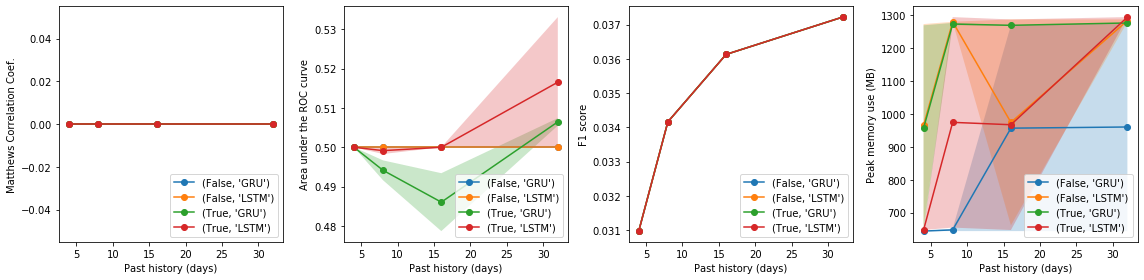

In [10]:
# plot results

results['past_history'] = results['past_history'].astype('float64')
conditions = results.groupby(['statefullness', 'RNN_type'])

plt.subplots(1, 4, figsize=(16, 4))

plt.subplot(1, 4, 1)

for name, group in conditions:
    x = np.array(group['past_history'])
    y = np.array(group['matthews_correlation'])
    y_err = np.array(group['matthews_correlation_stdev'])
    plt.plot(x, y, marker="o", linestyle="-", label=name)
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)
    
    plt.legend(loc="lower right")
    plt.xlabel('Past history (days)')
    plt.ylabel('Matthews Correlation Coef.')
    
plt.subplot(1, 4, 2)

for name, group in conditions:
    x = np.array(group['past_history'])
    y = np.array(group['AUC'])
    y_err = np.array(group['AUC_stdev'])
    plt.plot(x, y, marker="o", linestyle="-", label=name)
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)
    
    plt.legend(loc="lower right")
    plt.xlabel('Past history (days)')
    plt.ylabel('Area under the ROC curve')

plt.subplot(1, 4, 3)
    
for name, group in conditions:
    x = np.array(group['past_history'])
    y = np.array(group['F1'])
    y_err = np.array(group['F1_stdev'])
    plt.plot(x, y, marker="o", linestyle="-", label=name)
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)
    
    plt.legend(loc="lower right")
    plt.xlabel('Past history (days)')
    plt.ylabel('F1 score')
    
plt.subplot(1, 4, 4)

for name, group in conditions:
    x = np.array(group['past_history'])
    y = np.array(group['peak_memory'] / 10**6)
    y_err = np.array(group['peak_memory_stdev'] / 10**6)
    plt.plot(x, y, marker="o", linestyle="-", label=name)
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)
    
    plt.legend(loc="lower right")
    plt.xlabel('Past history (days)')
    plt.ylabel('Peak memory use (MB)')
    
plt.tight_layout()

In [11]:
# set run hyperparameters

hyperparameters = {
    'recurrent_unit_type': 'LSTM',
    'statefullness': False,
    'units': 5,
    'learning_rate': 0.01,
    'batch_size': 128,
    'past_history': 8,
    'dropout': 0.03,
    'class_weight': class_weight,
    'initial_output_bias': output_bias,
    'future_target': 1,
    'step': 1,
    'test_data_frac': 0.1,
    'validation_data_frac': 0.5,
    'training_epochs': 25,
    'verbose': 0
}

# set parameters to vary 

experimental_parameters = ['statefullness','batch_size']

parameter_sets = {
    'Stateless GRU, batch size 8': [False, 8],
    'Stateless GRU, batch size 16': [False, 16],
    'Stateless GRU, batch size 32': [False, 32],
    'Stateless GRU, batch size 64': [False, 64],
    'Stateless GRU, batch size 128': [False, 128],
    'Stateless GRU, batch size 256': [False, 256],
    'Stateless GRU, batch size 512': [False, 512],
#     'Stateless GRU, batch size 1024': [False, 1024],
    'Statefull GRU, batch size 8': [True, 8],
    'Statefull GRU, batch size 16': [True, 16],
    'Statefull GRU, batch size 32': [True, 32],
    'Statefull GRU, batch size 64': [True, 64],
    'Statefull GRU, batch size 128': [True, 128],
    'Statefull GRU, batch size 256': [True, 256],
    'Statefull GRU, batch size 512': [True, 512],
#     'Statefull GRU, batch size 1024': [True, 1024]
}

# set up pandas dataframe to hold results

metric_names = ['loss'] + list(metrics.keys())
metric_mean_names = []
metric_std_names = []

for metric_name in metric_names:
    metric_mean_names.append(metric_name)
    metric_std_names.append(f'{metric_name}_stdev')
    
column_names = ['description', 'peak_memory', 'peak_memory_stdev'] + experimental_parameters + metric_mean_names + metric_std_names
results = pd.DataFrame(columns = column_names)

NameError: name 'class_weight' is not defined

In [ ]:
# Do training runs on experimental conditions

num_repititions = 3
total_training_runs = num_repititions * len(parameter_sets)

for description, parameter_set in parameter_sets.items():
    run_results = []
    memory_use = []
    
    for i in range(num_repititions):
        print(f'{description}, run {i}, {total_training_runs} remaining')

        GRU_RNN = NeuralNet(hyperparameters, list(metrics.values()), data)

        GRU_RNN.statefullness = parameter_set[0]
        GRU_RNN.past_history = parameter_set[1]

        GRU_RNN.prep_data()
        
        tracemalloc.start()
        GRU_RNN.build_model()
        GRU_RNN.train_model()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memory_use.append(peak)

        result = GRU_RNN.evaluate_model()
        run_results.append(result)
        
        total_training_runs -= 1
        
    run_means = np.array(run_results).mean(axis=0)
    run_stdev = np.array(run_results).std(axis=0)
    peak_memory_mean = np.array(memory_use).mean()
    peak_memory_std = np.array(memory_use).std()
    result_row = [description, peak_memory_mean, peak_memory_std] + parameter_set + list(run_means) + list(run_stdev)
    results.loc[len(results)] = result_row   

In [ ]:
# plot results

results['batch_size'] = results['batch_size'].astype('float64')
conditions = results.groupby(['statefullness'])

plt.subplots(1, 4, figsize=(16,4))

plt.subplot(1, 4, 1)

for name, group in conditions:
    x = np.array(group['batch_size'])
    y = np.array(group['matthews_correlation'])
    y_err = np.array(group['matthews_correlation_stdev'])
    plt.plot(x, y, marker="o", linestyle="-", label=name)
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)
    
    plt.legend(loc="lower right")
    plt.xlabel('Batch size')
    plt.ylabel('Matthews Correlation Coef.')

plt.subplot(1, 4, 2)

for name, group in conditions:
    x = np.array(group['batch_size'])
    y = np.array(group['AUC'])
    y_err = np.array(group['AUC_stdev'])
    plt.plot(x, y, marker="o", linestyle="-", label=name)
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)
    
    plt.legend(loc="lower right")
    plt.xlabel('Batch size')
    plt.ylabel('Area under the ROC curve')

plt.subplot(1, 4, 3)
    
for name, group in conditions:
    x = np.array(group['batch_size'])
    y = np.array(group['F1'])
    y_err = np.array(group['F1_stdev'])
    plt.plot(x, y, marker="o", linestyle="-", label=name)
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)
    
    plt.legend(loc="lower right")
    plt.xlabel('Batch size')
    plt.ylabel('F1 score')
    
plt.subplot(1, 4, 4)

for name, group in conditions:
    x = np.array(group['batch_size'])
    y = np.array(group['peak_memory'] / 10**6)
    y_err = np.array(group['peak_memory_stdev'] / 10**6)
    plt.plot(x, y, marker="o", linestyle="-", label=name)
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)
    
    plt.legend(loc="lower right")
    plt.xlabel('Batch size')
    plt.ylabel('Peak memory use (MB)')
    
plt.tight_layout()

In [ ]:
# set run hyperparameters

hyperparameters = {
    'recurrent_unit_type': 'GRU',
    'statefullness': False,
    'units': 5,
    'learning_rate': 0.01,
    'batch_size': 256,
    'past_history': 8,
    'dropout': 0.03,
    'class_weight': class_weight,
    'initial_output_bias': output_bias,
    'future_target': 1,
    'step': 1,
    'test_data_frac': 0.1,
    'validation_data_frac': 0.5,
    'training_epochs': 25,
    'verbose': 0
}

# set parameters to vary 

experimental_parameters = ['units']

parameter_sets = {
    'GRU units: 1': [1],
    'GRU units: 2': [2],
    'GRU units: 3': [3],
    'GRU units: 4': [4],
    'GRU units: 5': [5],
    'GRU units: 6': [6],
    'GRU units: 7': [7],
    'GRU units: 8': [8],
    'GRU units: 9': [9],
    'GRU units: 10': [10]
}

# set up pandas dataframe to hold results

metric_names = ['loss'] + list(metrics.keys())
metric_mean_names = []
metric_std_names = []

for metric_name in metric_names:
    metric_mean_names.append(metric_name)
    metric_std_names.append(f'{metric_name}_stdev')
    
column_names = ['description', 'peak_memory', 'peak_memory_stdev'] + experimental_parameters + metric_mean_names + metric_std_names
results = pd.DataFrame(columns = column_names)

In [ ]:
# Do training runs on experimental conditions

num_repititions = 3
total_training_runs = num_repititions * len(parameter_sets)

for description, parameter_set in parameter_sets.items():
    run_results = []
    memory_use = []
    
    for i in range(num_repititions):
        print(f'{description}, run {i}, {total_training_runs} remaining')

        GRU_RNN = NeuralNet(hyperparameters, list(metrics.values()), data)

        GRU_RNN.units = parameter_set[0]

        GRU_RNN.prep_data()
        
        tracemalloc.start()
        GRU_RNN.build_model()
        GRU_RNN.train_model()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memory_use.append(peak)

        result = GRU_RNN.evaluate_model()
        run_results.append(result)
        
        total_training_runs -= 1
        
    run_means = np.array(run_results).mean(axis=0)
    run_stdev = np.array(run_results).std(axis=0)
    peak_memory_mean = np.array(memory_use).mean()
    peak_memory_std = np.array(memory_use).std()
    result_row = [description, peak_memory_mean, peak_memory_std] + parameter_set + list(run_means) + list(run_stdev)
    results.loc[len(results)] = result_row 

In [ ]:
# plot results

results['units'] = results['units'].astype('float64')

plt.subplots(1, 4, figsize=(16,4))

plt.subplot(1, 4, 1)

x = np.array(results['units'])
y = np.array(results['matthews_correlation'])
y_err = np.array(results['matthews_correlation_stdev'])
plt.plot(x, y, marker="o", linestyle="-", label=name)
plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)

plt.legend(loc="lower right")
plt.xlabel('GRU units')
plt.ylabel('Matthews Correlation Coef.')
    
plt.subplot(1, 4, 2)

x = np.array(results['units'])
y = np.array(results['AUC'])
y_err = np.array(results['AUC_stdev'])
plt.plot(x, y, marker="o", linestyle="-", label=name)
plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)

plt.legend(loc="lower right")
plt.xlabel('GRU units')
plt.ylabel('Area under the ROC curve')

plt.subplot(1, 4, 3)
    
x = np.array(results['units'])
y = np.array(results['F1'])
y_err = np.array(results['F1_stdev'])
plt.plot(x, y, marker="o", linestyle="-", label=name)
plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)

plt.legend(loc="lower right")
plt.xlabel('GRU units')
plt.ylabel('F1 score')
    
plt.subplot(1, 4, 4)

x = np.array(results['units'])
y = np.array(results['peak_memory'] / 10**6)
y_err = np.array(results['peak_memory_stdev'] / 10**6)
plt.plot(x, y, marker="o", linestyle="-", label=name)
plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)

plt.legend(loc="lower right")
plt.xlabel('GRU units')
plt.ylabel('Peak memory use (MB)')
    
plt.tight_layout()

In [ ]:
# set run hyperparameters

hyperparameters = {
    'recurrent_unit_type': 'GRU',
    'statefullness': False,
    'units': 8,
    'learning_rate': 0.01,
    'batch_size': 256,
    'past_history': 8,
    'dropout': 0.03,
    'class_weight': class_weight,
    'initial_output_bias': output_bias,
    'future_target': 1,
    'step': 1,
    'test_data_frac': 0.1,
    'validation_data_frac': 0.5,
    'training_epochs': 25,
    'verbose': 0
}

# set parameters to vary 

experimental_parameters = ['dropout']

parameter_sets = {
    'Dropout: 0.01': [0.01],
    'Dropout: 0.05': [0.05],
    'Dropout: 0.10': [0.10],
    'Dropout: 0.15': [0.15],
    'Dropout: 0.20': [0.20],
    'Dropout: 0.25': [0.25],
    'Dropout: 0.30': [0.30]
}

# set up pandas dataframe to hold results

metric_names = ['loss'] + list(metrics.keys())
metric_mean_names = []
metric_std_names = []

for metric_name in metric_names:
    metric_mean_names.append(metric_name)
    metric_std_names.append(f'{metric_name}_stdev')
    
column_names = ['description', 'peak_memory', 'peak_memory_stdev'] + experimental_parameters + metric_mean_names + metric_std_names
results = pd.DataFrame(columns = column_names)

In [ ]:
# Do training runs on experimental conditions

num_repititions = 3
total_training_runs = num_repititions * len(parameter_sets)

for description, parameter_set in parameter_sets.items():
    run_results = []
    memory_use = []
    
    for i in range(num_repititions):
        print(f'{description}, run {i}, {total_training_runs} remaining')

        GRU_RNN = NeuralNet(hyperparameters, list(metrics.values()), data)
        GRU_RNN.dropout = parameter_set[0]
        GRU_RNN.prep_data()
        
        tracemalloc.start()
        GRU_RNN.build_model()
        GRU_RNN.train_model()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memory_use.append(peak)

        result = GRU_RNN.evaluate_model()
        run_results.append(result)
        
        total_training_runs -= 1
        
    run_means = np.array(run_results).mean(axis=0)
    run_stdev = np.array(run_results).std(axis=0)
    peak_memory_mean = np.array(memory_use).mean()
    peak_memory_std = np.array(memory_use).std()
    result_row = [description, peak_memory_mean, peak_memory_std] + parameter_set + list(run_means) + list(run_stdev)
    results.loc[len(results)] = result_row 

In [ ]:
# plot results

#results['units'] = results['units'].astype('float64')

plt.subplots(1, 4, figsize=(16,4))

plt.subplot(1, 4, 1)

x = np.array(results['dropout'])
y = np.array(results['matthews_correlation'])
y_err = np.array(results['matthews_correlation_stdev'])
plt.plot(x, y, marker="o", linestyle="-")
plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)

plt.xlabel('Dropout rate')
plt.ylabel('Matthews Correlation Coef.')
    
plt.subplot(1, 4, 2)

x = np.array(results['dropout'])
y = np.array(results['AUC'])
y_err = np.array(results['AUC_stdev'])
plt.plot(x, y, marker="o", linestyle="-")
plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)

plt.xlabel('Dropout rate')
plt.ylabel('Area under the ROC curve')

plt.subplot(1, 4, 3)
    
x = np.array(results['dropout'])
y = np.array(results['F1'])
y_err = np.array(results['F1_stdev'])
plt.plot(x, y, marker="o", linestyle="-")
plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)

plt.xlabel('Dropout rate')
plt.ylabel('F1 score')
    
plt.subplot(1, 4, 4)

x = np.array(results['dropout'])
y = np.array(results['peak_memory'] / 10**6)
y_err = np.array(results['peak_memory_stdev'] / 10**6)
plt.plot(x, y, marker="o", linestyle="-")
plt.fill_between(x, y-y_err, y+y_err, alpha=0.25)

plt.xlabel('Dropout rate')
plt.ylabel('Peak memory use (MB)')
    
plt.tight_layout()